In [7]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt

In [8]:
a=pd.read_csv('./TSPA.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])


In [9]:
coordinates=tspa[['x', 'y']].values

In [ ]:
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
dist+=a

In [11]:
costs=tspa[['val']].values

In [12]:
cost_m=dist+costs

In [54]:
def plot_solution(result_list: list, coordinates: np.ndarray, weights: np.ndarray) -> None:
    plt.figure(figsize=(12, 8))
    for i1, i2 in zip(result_list, result_list[1:] + result_list[:1]):
        point1 = coordinates[i1]
        point2 = coordinates[i2]
        plt.plot(
            [point1[0], point2[0]],
            [point1[1], point2[1]],
            c = 'black',
            zorder=1
        )

    scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=weights, cmap='viridis', s=50)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Weights')

    plt.show()


In [56]:
def get_random_solution(n: int) -> list:
    a=np.arange(0,n)
    np.random.shuffle(a)
    return list(a[:n//2])

In [57]:
def nn(starting_point: int, cost_matrix: np.ndarray) -> list:
    result_list=[starting_point]
    n = cost_matrix.shape[0]
    for x in range(n//2-1):
        distances=cost_matrix[result_list[-1]]
        indices=np.arange(0,n)
        di_pairs=[(d, i) for d, i in zip(distances,indices) if i not in result_list]
        nearest_neighbor = min(di_pairs)
        result_list.append(nearest_neighbor[1])
    return result_list

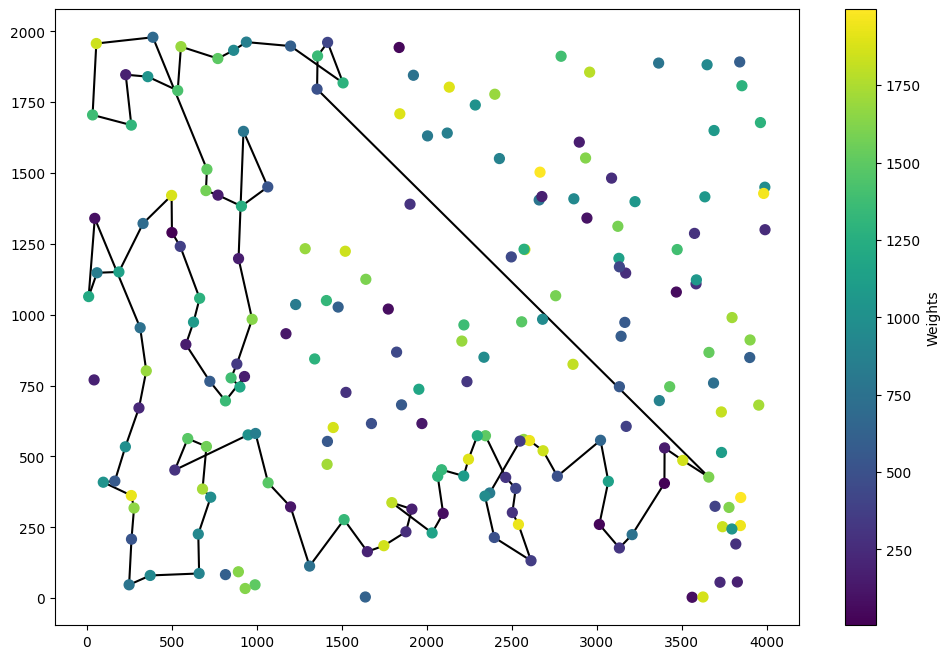

In [58]:
solution = nn(0, cost_m)
plot_solution(solution, coordinates, costs)